In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sd3power","key":"3000c4b93d151ddd45b80bce853a84c5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           5926        178  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27            985         23  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           3900         89  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [ ]:
!wget https://www.kaggle.com/datasets/ssarkar445/covid-19-xray-and-ct-scan-image-dataset/download?datasetVersionNumber=1

--2022-12-07 06:56:26--  https://www.kaggle.com/datasets/ssarkar445/covid-19-xray-and-ct-scan-image-dataset/download?datasetVersionNumber=1
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fdatasets%2Fssarkar445%2Fcovid-19-xray-and-ct-scan-image-dataset%2Fversions%2F1%3Fresource%3Ddownload [following]
--2022-12-07 06:56:27--  https://www.kaggle.com/account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fdatasets%2Fssarkar445%2Fcovid-19-xray-and-ct-scan-image-dataset%2Fversions%2F1%3Fresource%3Ddownload
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘download?datasetVersionNumber=1’

d

In [ ]:
!kaggle datasets download -d ssarkar445/covid-19-xray-and-ct-scan-image-dataset
!unzip covid-19-xray-and-ct-scan-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19 Dataset/X-ray/Non-COVID/01.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/010.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0100.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0101.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0102.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0103.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0104.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0105.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0106.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0107.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0108.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0109.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/011.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0110.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0111.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0112.jpeg  
  inflating: COVID-19 Dat

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.8 MB/s 


In [ ]:
#run from here
import glob
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision
from torch.optim.lr_scheduler import StepLR

In [ ]:
covid=glob.glob('/content/COVID-19 Dataset/CT/COVID/*')
non_covid=glob.glob('/content/COVID-19 Dataset/CT/Non-COVID/*')
print(len(covid))
print(len(non_covid))

5427
2628


In [ ]:
covid = [(path, 1) for path in covid]
non_covid = [(path, 0) for path in non_covid]

In [ ]:
covid_train ,covid_test = train_test_split(covid,test_size=0.2,random_state=75)
non_covid_train,non_covid_test=train_test_split(non_covid,test_size=0.2,random_state=50)

In [ ]:
class myloader():
    def __init__(self, dataset):
        self.dataset=dataset
        transform_list = []
        transform_list += [transforms.ToTensor()]
        transform_list += [transforms.Resize([256,256])]
        transform_list += [transforms.RandomRotation(360)]
        transform_list += [transforms.RandomHorizontalFlip(p=0.2)]
        transform_list += [transforms.RandomVerticalFlip(p=0.2)]
        preprocess = transforms.Compose(transform_list)
        self.preprocess = preprocess
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
      im=Image.open(self.dataset[idx][0])
      im=im.convert("RGB")
      im=self.preprocess(im)/255.0
      target=torch.zeros((2,1))
      target[self.dataset[idx][1]]=1
      return im,target

In [ ]:
train=covid_train+non_covid_train
test=covid_test+non_covid_test
print(len(train))
print(len(test))

6443
1612


In [ ]:
train_loader = myloader(train)
test_loader = myloader(test)

train=torch.utils.data.DataLoader(train_loader,64,True)
test=torch.utils.data.DataLoader(test_loader,128,False)

In [ ]:
den=torchvision.models.densenet121(pretrained=True)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=nn.Sequential(
                    den,
                    nn.ReLU(),
                    nn.Linear(1000,2))
model.to(device)
optim=torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
n = 25
metric0 = BinaryF1Score()
metric1 = BinaryAccuracy()
metric2 = BinaryPrecision()
softmax=nn.Softmax(dim=1)
loss_train = []
loss_test = []
test_acc=[]

scheduler = StepLR(optim, step_size=20, gamma=0.8)
cri=nn.CrossEntropyLoss()
cri.to(device)
cur_loss=10
m_los=10

In [ ]:
for epoch in range(n):
  model.train()
  los_test = []
  los_train = []
  f1_list = []
  acc_list = []
  pre_list = []
  for (x_tr, tar) in train:  
    x_tr = x_tr.to(device)
    tar = tar.to(device)
    optim.zero_grad()
    out=model(x_tr)
    tar=tar.squeeze(2)
    loss = cri(out, tar)
    loss.backward()
    los_train.append(loss.item())
    optim.step()
  loss_train.append(sum(los_train)/len(los_train))
  print(f'epoch {epoch} train loss : {sum(los_train)/len(los_train)}')
  acc=[]
  with torch.no_grad():
    model.eval()
    for x_tes, testtar in test:
      x_tes = x_tes.to(device)
      testtar = testtar.to(device)
      testtar=testtar.squeeze(2)
      outt = model(x_tes)
      outt=softmax(outt)
      f1_list.append(metric0(outt.cpu(), testtar.cpu()))
      # acc_list.append(metric1(outt.cpu(), testtar.cpu()))
      pre_list.append(metric2(outt.cpu(), testtar.cpu()))
      losss = cri(outt, testtar)
      los_test.append(losss.item())
      acc.append(metric1(outt.cpu(), testtar.cpu()))
    test_acc.append(sum(acc)/len(acc))
    loss_test.append(sum(los_test)/len(los_test))
    print(f'epoch {epoch} test loss : {sum(los_test)/len(los_test)}')
    print(f'epoch {epoch} F1 : {sum(f1_list)/len(f1_list)}')
    print(f'epoch {epoch} Acc : {sum(acc)/len(acc)}')
    print(f'epoch {epoch} Pre : {sum(pre_list)/len(pre_list)}')
    if(loss_test[-1]<=min(loss_test)):
       print(f'epoch {epoch} '+'Model Saved')
       torch.save(model,'best.pth')

epoch 0 train loss : 0.9262085610096997
epoch 0 test loss : 0.6005700689095718
epoch 0 F1 : 0.6750379800796509
epoch 0 Acc : 0.6750379800796509
epoch 0 Pre : 0.6750379800796509
epoch 0 Model Saved
epoch 1 train loss : 0.32957283090246786
epoch 1 test loss : 0.4651241279565371
epoch 1 F1 : 0.8382464051246643
epoch 1 Acc : 0.8382464051246643
epoch 1 Pre : 0.8382464051246643
epoch 1 Model Saved
epoch 2 train loss : 0.29264643065410084
epoch 2 test loss : 0.44694080031835115
epoch 2 F1 : 0.86269611120224
epoch 2 Acc : 0.86269611120224
epoch 2 Pre : 0.86269611120224
epoch 2 Model Saved
epoch 3 train loss : 0.27665989875498387
epoch 3 test loss : 0.4745581310528975
epoch 3 F1 : 0.8168649077415466
epoch 3 Acc : 0.8168649077415466
epoch 3 Pre : 0.8168649077415466
epoch 4 train loss : 0.27991324205799856
epoch 4 test loss : 0.4631412739937122
epoch 4 F1 : 0.8647204041481018
epoch 4 Acc : 0.8647204041481018
epoch 4 Pre : 0.8647204041481018
epoch 5 train loss : 0.2638031790162077
epoch 5 test los

In [ ]:
model=torch.load('best.pth')

In [ ]:
print(loss_test)
print(loss_train)

[0.6005700689095718, 0.4651241279565371, 0.44694080031835115, 0.4745581310528975, 0.4631412739937122, 0.4655889249764956, 0.507743626832962, 0.5782391933294443, 0.5946685144534478, 0.4541244300512167, 0.4592374792465797, 0.4608714488836435, 0.45536272342388445, 0.5731079257451571, 0.4687094986438751, 0.5269352954167587, 0.5050034889808068, 0.46043968888429493, 0.4845142731299767, 0.6680575769681197, 0.581099503315412, 0.41733940748068005, 0.4562491751634158, 0.41443236745320833, 0.4245278858221494]
[0.9262085610096997, 0.32957283090246786, 0.29264643065410084, 0.27665989875498387, 0.27991324205799856, 0.2638031790162077, 0.2551795894851779, 0.259230838406204, 0.2765076132399021, 0.25724300380685544, 0.25397881813863715, 0.24142607426879428, 0.2405172359235216, 0.23671721504761442, 0.24607266529951946, 0.23368040826356057, 0.24546571039032228, 0.22784577878099857, 0.23421574052017513, 0.23204499497862147, 0.23907689137919114, 0.22596851588770894, 0.23701165963222484, 0.22140486331859438

In [ ]:
print(test_acc)

[tensor(0.6750), tensor(0.8382), tensor(0.8627), tensor(0.8169), tensor(0.8647), tensor(0.8408), tensor(0.7899), tensor(0.6932), tensor(0.6886), tensor(0.8520), tensor(0.8431), tensor(0.8636), tensor(0.8955), tensor(0.7106), tensor(0.8357), tensor(0.7675), tensor(0.7936), tensor(0.8355), tensor(0.8128), tensor(0.5949), tensor(0.7078), tensor(0.9038), tensor(0.8609), tensor(0.9065), tensor(0.9057)]


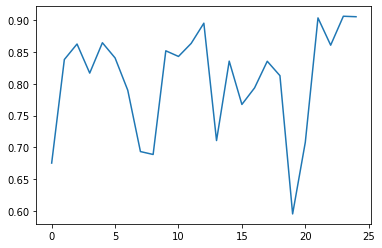

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_acc)
plt.show()

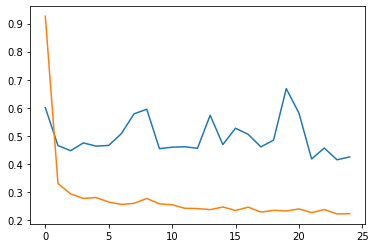

In [ ]:
plt.plot(loss_test)
plt.plot(loss_train)
plt.show()

In [ ]:
targets = torch.Tensor().to('cuda')
preds = torch.Tensor().to('cuda')
with torch.no_grad():
    model.eval()
    for x_tes, testtar in test:
      x_tes = x_tes.to(device)
      testtar = testtar.to(device)
      testtar=testtar.squeeze(2)
      outt = model(x_tes)
      outt=softmax(outt)

      targets = torch.cat((targets,testtar))
      preds = torch.cat((preds,outt))


In [ ]:
out = (preds>0.5).float()
out

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')

In [ ]:
outtt = torch.zeros(out.shape[0])
for i in range(out.shape[0]):
  outtt[i] = out[i][0]

In [ ]:
targetsss = torch.zeros(targets.shape[0])
for i in range(targets.shape[0]):
  targetsss[i] = targets[i][0]

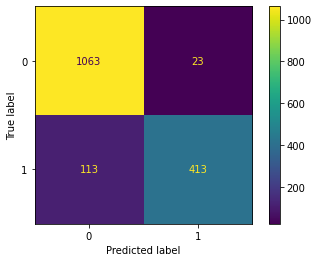

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(targetsss.cpu(), outtt.cpu())
ConfusionMatrixDisplay(cm).plot()